Article link: [Toward data science](https://towardsdatascience.com/data-to-text-generation-with-t5-building-a-simple-yet-advanced-nlg-model-b5cce5a6df45)




## Installing the required packages

In [1]:
# !pip install transformers
# !pip install sentencepiece

## Importing required libraries

In [2]:
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')

2021-10-26 14:52:06.797163: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-26 14:52:06.797214: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Preprocess the data

In [4]:
import urllib.request
import zipfile
url = 'https://gitlab.com/shimorina/webnlg-dataset/-/archive/master/webnlg-dataset-master.zip?path=release_v3.0/en/train'
urllib.request.urlretrieve(url, 'web.zip')
with zipfile.ZipFile('web.zip', 'r') as zip_ref:
    zip_ref.extractall('web')
import glob
import os
import re
import xml.etree.ElementTree as ET
import pandas as pd
files = glob.glob("/content/web/webnlg-dataset-master-release_v3.0-en-train/release_v3.0/en/train/**/*.xml", recursive=True)
triple_re=re.compile('(\d)triples')
data_dct={}
for file in files:
    tree = ET.parse(file)
    root = tree.getroot()
    triples_num=int(triple_re.findall(file)[0])
    for sub_root in root:
        for ss_root in sub_root:
            strutured_master=[]
            unstructured=[]
            for entry in ss_root:
                unstructured.append(entry.text)
                strutured=[triple.text for triple in entry]
                strutured_master.extend(strutured)
            unstructured=[i for i in unstructured if i.replace('\n','').strip()!='' ]
            strutured_master=strutured_master[-triples_num:]
            strutured_master_str=(' && ').join(strutured_master)
            data_dct[strutured_master_str]=unstructured
mdata_dct={"prefix":[], "input_text":[], "target_text":[]}
for st,unst in data_dct.items():
    for i in unst:
        mdata_dct['prefix'].append('webNLG')
        mdata_dct['input_text'].append(st)
        mdata_dct['target_text'].append(i)


df=pd.DataFrame(mdata_dct)
df.to_csv('webNLG2020_train.csv')

In [5]:
train_df=pd.read_csv('webNLG2020_train.csv', index_col=[0])

Trimming off a few data points and so that a batch would not leave any remainder, hence some lines of codes can be avoided (Okay, this might be a hackish way of doing it )

In [6]:
train_df.head()

,prefix,input_text,target_text
0,webNLG,1955_Dodge | engine | 230 (cubic inches) && 19...,The 1955 Dodge is a convertible with a 230 cub...
1,webNLG,1955_Dodge | engine | 230 (cubic inches) && 19...,The 1955 Dodge convertible's engine size is 23...
2,webNLG,1955_Dodge | engine | 230 (cubic inches) && 19...,The 1955 Dodge is a convertible and has a 230 ...
3,webNLG,1955_Dodge | engine | 230 (cubic inches) && 19...,The 1955 Dodge has a hardtop and it engine is ...
4,webNLG,1955_Dodge | engine | 230 (cubic inches) && 19...,"The 1955 Dodge, has an engine size of 230 cubi..."


In [7]:
# train_df=train_df.iloc[  :35000,:]

In [10]:
train_df.sample(10)

,prefix,input_text,target_text
22406,webNLG,Paulo_Sousa | club | ACF_Fiorentina,Paulo Sousa plays for ACF Fiorentina.
7796,webNLG,Alfa_Romeo_164 | bodyStyle | Sedan_(automobile...,The Alfa Romeo 164 has a Sedan body style and ...
34705,webNLG,Alfredo_Zitarrosa | associatedBand/associatedM...,"Alfredo Zitarrosa, who has a background as a s..."
1471,webNLG,Buzz_Aldrin | awards | 20 && Buzz_Aldrin | alm...,Buzz Aldrin graduated from the Massachusetts I...
34703,webNLG,Alfred_Garth_Jones | deathPlace | Sidcup && Un...,Alfred Garth Jones was born in the UK where th...
33058,webNLG,11264_Claudiomaccone | averageSpeed | 18.29 (k...,"11264 Claudiomaccone, discovered by Nikolai Ch..."
16556,webNLG,Alfred_Moore_Scales | party | Democratic_Party...,Alfred Moore Scales is a member of the Democra...
7453,webNLG,Monocacy_National_Battlefield | location | Fre...,The 14th New Jersey Volunteer Infantry Monumen...
7104,webNLG,School of Business and Social Sciences at the ...,The School of Business and Social Sciences at ...
5194,webNLG,Alcatraz_Versus_the_Evil_Librarians | oclcNumb...,Alcatraz Versus The Evil Librarians is produce...


### Add some questions into training dataset


In [8]:
add_questions = {
    'prefix': ['webNLG', 
               'webNLG', 
               'webNLG',
               'webNLG',
               'webNLG',
               'webNLG'],
    'input_text': ['how_much | laptop | cost', 
                   'how_much | phone | cost',
                   'what | your | name',
                   'what | your | name',
                   'phone | beautiful',
                   'laptop | beautiful'],
    'target_text': ['how much does the laptop cost',
                    'how much does the phone cost',
                    'what is your name',
                    'what is your name',
                    'the phone is beautiful',
                    'the laptop is beautiful']
}

In [11]:
add_df = pd.DataFrame(add_questions)
add_df


,prefix,input_text,target_text
0,webNLG,how_much | laptop | cost,how much does the laptop cost
1,webNLG,how_much | phone | cost,how much does the phone cost
2,webNLG,what | your | name,what is your name
3,webNLG,what | your | name,what is your name
4,webNLG,phone | beautiful,the phone is beautiful
5,webNLG,laptop | beautiful,the laptop is beautiful


In [12]:
train_df = pd.concat([train_df, add_df], ignore_index=True)
train_df


,prefix,input_text,target_text
0,webNLG,1955_Dodge | engine | 230 (cubic inches) && 19...,The 1955 Dodge is a convertible with a 230 cub...
1,webNLG,1955_Dodge | engine | 230 (cubic inches) && 19...,The 1955 Dodge convertible's engine size is 23...
2,webNLG,1955_Dodge | engine | 230 (cubic inches) && 19...,The 1955 Dodge is a convertible and has a 230 ...
3,webNLG,1955_Dodge | engine | 230 (cubic inches) && 19...,The 1955 Dodge has a hardtop and it engine is ...
4,webNLG,1955_Dodge | engine | 230 (cubic inches) && 19...,"The 1955 Dodge, has an engine size of 230 cubi..."
...,...,...,...
35194,webNLG,how_much | phone | cost,how much does the phone cost
35195,webNLG,what | your | name,what is your name
35196,webNLG,what | your | name,what is your name
35197,webNLG,phone | beautiful,the phone is beautiful


In [13]:
# Shuffle dataframe
train_df=train_df.sample(frac = 1)
train_df.shape

(35199, 3)

In [14]:
train_df

,prefix,input_text,target_text
9115,webNLG,Elliot_See | almaMater | University_of_Texas_a...,Elliot See (born in Dallas) went to the Univer...
21442,webNLG,Al_Asad_Airbase | elevationAboveTheSeaLevelInF...,Al Asad Airbase has an elevation above the sea...
14574,webNLG,Accademia_di_Architettura_di_Mendrisio | count...,The Accademia di Architettura di Mendrisio in ...
33380,webNLG,Agnes_Kant | nationality | Netherlands && Neth...,"Mark Rutte is the leader of the Netherlands, w..."
2186,webNLG,Amatriciana_sauce | region | Lazio && Amatrici...,Lazio's regional Amatriciana sauce includes Pe...
...,...,...,...
30796,webNLG,Asilomar_Conference_Grounds | architect | Juli...,"The architect Julia Morgan, who was born in Ca..."
13713,webNLG,"Alan_Frew | origin | Newmarket,_Ontario && Ala...","Alan Frew comes from Newmarket, Ontario, Canad..."
6391,webNLG,Andrew_White_(musician) | associatedBand/assoc...,"The band Kaiser Chiefs included the member, mu..."
23566,webNLG,"Asilomar_Conference_Grounds | location | ""Asil...",The Asilomar Conference Grounds is located in ...


## Checking for the GPU availability

In [15]:
if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


## Loading the pretrained model and tokenizer

In [16]:
# Load model:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [17]:
model.config

T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 300,
      "num_beams": 4,
      "prefix": "translate English to German: "
    },
    "translation_en_to_fr": {
      "early_stopping": tru

## Initializing the Adafactor optimizer with parameter values suggested for t5

In [18]:

optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

  

Html based progress bar.

In [19]:

from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

## Training the model

### Batchsize config


In [20]:
# Batchsize config.
batch_size=8
num_of_batches=len(train_df)/batch_size
num_of_batches=int(num_of_batches)
num_of_epochs=2

print('batch size', batch_size)
print('no. batches', num_of_batches)
print('no. epochs', num_of_epochs)


batch size 8
no. batches 4399
no. epochs 2


In [21]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)

  # Loop through each batch of data
  for i in range(num_of_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size] # get each of batch of data

    # Loop through each row of new_df and get inputpatch and labelbatch
    for indx,row in new_df.iterrows():
      input = 'WebNLG: '+row['input_text']+'</s>' # command
      labels = row['target_text']+'</s>'   
      inputbatch.append(input)
      labelbatch.append(labels)

    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
    
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  

Running epoch: 1


Epoch: 1 , Running loss: 0.49938689825019394
Running epoch: 2


Epoch: 2 , Running loss: 0.37890580609850677


In [ ]:
model.config

T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 300,
      "num_beams": 4,
      "prefix": "translate English to German: "
    },
    "translation_en_to_fr": {
      "early_stopping": tru

## Plotting the loss over time

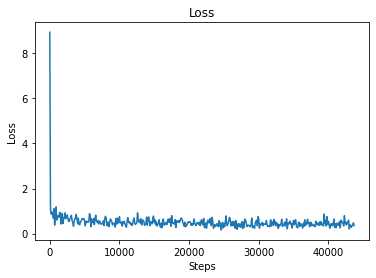

In [ ]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

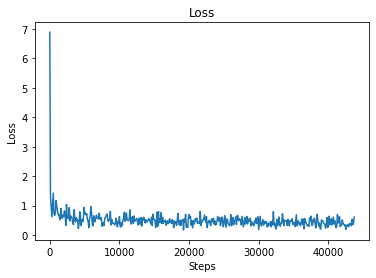

In [ ]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

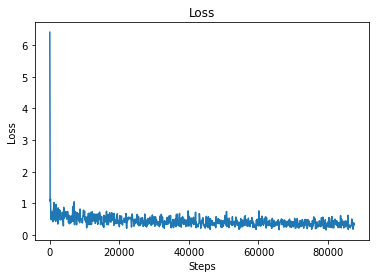

In [ ]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

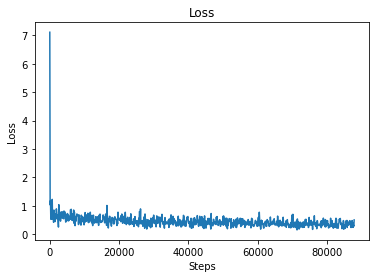

In [ ]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

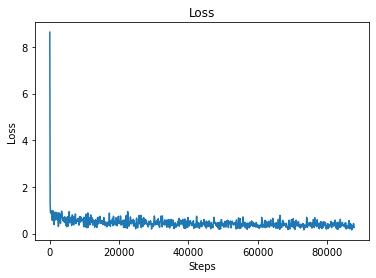

In [ ]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

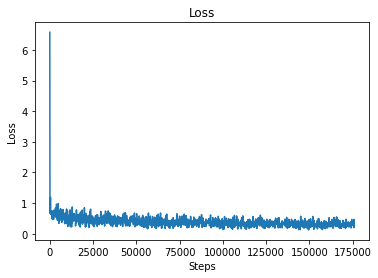

In [ ]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

## Testing the model

In [ ]:
model.eval()
input_ids = tokenizer.encode("WebNLG: sidharth | play | football </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0])

'<pad> Sidharth plays for the football team.</s>'

## Saving model

Before testing the model further, lets learn how to serialize it and load from the path

In [ ]:
import datetime
str(datetime.datetime.now().date())

'2021-10-25'

In [22]:
import datetime

now = str(datetime.datetime.now().date())
torch.save(model.state_dict(),'T5_pretrainedmodel_{}.bin'.format(now))

The configuration file for the t5 base model can be downloaded and placed on the same directory as the saved model. Make sure to rename it to config.json

## Load model

In [ ]:
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json

--2021-10-25 11:59:43--  https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.142.216
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.142.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1199 (1.2K) [application/json]
Saving to: ‘t5-base-config.json’

t5-base-config.json 100%[===================>]   1.17K  --.-KB/s    in 0s      

2021-10-25 11:59:43 (25.1 MB/s) - ‘t5-base-config.json’ saved [1199/1199]



In [ ]:
# Load saved model

tokenizer = T5Tokenizer.from_pretrained('t5-base')
model2 = T5ForConditionalGeneration.from_pretrained('T5_pretrainedmodel_2021-10-25.bin', return_dict=True,config='t5-base-config.json')



In [27]:

def generate(text,model,tokenizer):
   model.eval()
   input_ids = tokenizer.encode("WebNLG:{} </s>".format(text), 
                               return_tensors="pt")  
   input_ids=input_ids.to(dev)
   outputs = model.generate(input_ids)
   return tokenizer.decode(outputs[0])

In [28]:
generate('how_much | speaker | cost', model, tokenizer)

'<pad> how much does the speaker cost to build</s>'

In [30]:
generate('the_dog | beautiful', model, tokenizer)


'<pad> The Dog is beautiful</s>'

In [35]:
generate('how_much | phone | cost', model, tokenizer)

'<pad> how much does the phone cost to build</s>'

In [39]:
generate('phone | expensive', model, tokenizer)

'<pad> The phone is expensive.</s>'

In [ ]:
generate('I | want | back | school', model, tokenizer)


'<pad> The back up school was for I.</s>'

In [ ]:
generate('who | your_wife', model, tokenizer)


'<pad> The wife of who is called your wife.</s>'

In [ ]:
generate('Tam_company | foundingDate | 20-10-2012', model2, tokenizer)


'<pad> The founding date of the Tam company is 20-10-2012.</s>'

## Copy pretrained model to ggdrive

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
import shutil

shutil.copy('/content/T5_pretrainedmodel_2021-10-26.bin', 
            '/content/drive/MyDrive/Colab Notebooks/Projects/NLP_keywords_to_sentence/pretrained_model')

'/content/drive/MyDrive/Colab Notebooks/Projects/NLP_keywords_to_sentence/pretrained_model/T5_pretrainedmodel_2021-10-26.bin'